# Librerie e setup

In [1]:
!pip install astropy
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tasto destro sulla cartella Final Project --> aggiungi scorciatoia al MyDrive

In [3]:
%cd /content/drive/MyDrive/Final Project/AstroStatLearn/code/Neural Networks/RCNN/

/content/drive/.shortcut-targets-by-id/12oB0yfCn8EnscXWd4KOG5iZW5xfunRqy/Final Project/AstroStatLearn/code/Neural Networks/RCNN


Librerie

In [5]:
# librerie base
import matplotlib.image as mi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from tqdm import tqdm
import requests
import shutil
import time
import random
import json
import os
from pycocotools import mask
from skimage import measure
from skimage.util import view_as_blocks
#from patchify import patchify
from PIL import Image

# fits image
from astropy.io import fits
from astropy.visualization import ZScaleInterval, MinMaxInterval, LogStretch

# pytorch
import tensorflow as tf
import torch
from torch import nn
from torch._C import Size
from torch.utils.data import Dataset, DataLoader, sampler

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms as T
import torchvision

# import external libreries
import sys
sys.path.insert(0, './detection')

import utils
from engine import train_one_epoch, evaluate


norm = MinMaxInterval()
logstre = LogStretch(500)

# Creation of the dataset in format COCO

Following https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html 

As a first step we want something like:



```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```




In [ ]:
def generation_dataset(size, output_folder = ''): 
  
  # load the image
  path = '/content/drive/MyDrive/Final Project/AstroStatLearn/'
  img  = fits.getdata(path+'MC_vis/img_3.fits')
  mask = fits.getdata(path+"MC_vis/true.fits")
  rms  = fits.getdata(path+"MC_vis/rms.fits")

  # create the patch
  cc = 41
  print('> Patchando le immagini...')
  img_patches  = patchify(img[size:(size*cc), size:(size*cc)], (size, size), step = size)
  mask_patches = patchify(mask[size:(size*cc), size:(size*cc)],(size, size), step = size)
  rms_patches  = patchify(rms[size:(size*cc), size:(size*cc)], (size, size), step = size)

  dim1, dim2, _, _ = img_patches.shape

  if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    os.mkdir(output_folder+'/img')
    os.mkdir(output_folder+'/mask')
    os.mkdir(output_folder+'/rms')

  count = 0
  print("> Salvando i file fits...")
  for i in tqdm(range(dim1)):
    for j in range(dim2):
      #imgToSave = norm(img_patches[i][j]) + logstre(norm(rms_patches[i][j]))
      #hdu = fits.PrimaryHDU(norm(imgToSave))
      hdu = fits.PrimaryHDU(norm(img_patches[i][j]))
      hdu.writeto(output_folder + '/img/'+ str(count).zfill(6) +'.fits')
      hdu = fits.PrimaryHDU(mask_patches[i][j])
      hdu.writeto(output_folder + '/mask/'+ str(count).zfill(6) +'.fits')
      hdu = fits.PrimaryHDU(rms_patches[i][j])
      hdu.writeto(output_folder + '/rms/'+ str(count).zfill(6) +'.fits')
      count += 1

  return 

In [ ]:
size = 256
generation_dataset(size, output_folder = './astrodataset3n')

> Patchando le immagini...
> Salvando i file fits...


100%|██████████| 40/40 [01:15<00:00,  1.90s/it]


In [ ]:
#Sanity check, view few mages
lst = os.listdir('./astrodataset3n/img') # your directory path
print(len(lst))

1600


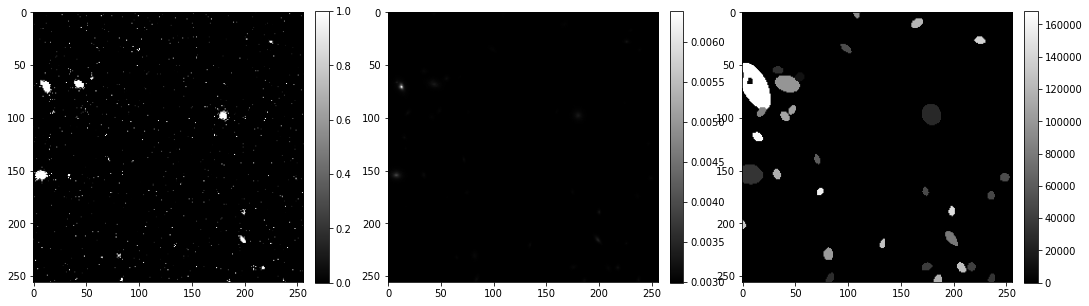

In [ ]:
rnd  = random.randint(0, len(lst)-1)

img = fits.getdata('./astrodataset3n/img/'+ str(rnd).zfill(6) +'.fits')
rms = fits.getdata('./astrodataset3n/rms/'+ str(rnd).zfill(6) +'.fits')
mask = fits.getdata('./astrodataset3n/mask/'+ str(rnd).zfill(6) +'.fits')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
im1  = ax1.imshow(img,  cmap='gray')
im2  = ax2.imshow(rms,  cmap='gray')
im3  = ax3.imshow(mask,  cmap='gray')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04);

Look at how many galaxy we have in the image ( are the label )

In [ ]:
np.unique(mask)

array([     0,   2697,  11943,  27528,  29585,  31123,  34738,  35243,
        38911,  41668,  46981,  49149,  50371,  50416,  57030,  60794,
        79276,  86345,  93010,  98002, 101534, 105973, 109636, 114933,
       116242, 119355, 126012, 127850, 131635, 139808, 146669, 158757,
       165993, 168322], dtype=int32)

# transform the dataset for the model

In [ ]:
class AstroStatCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, subset='train', add_rms=False, val_size=0.15, test_size=0.15, seed=1234):
        self.root = root
        self.transforms = transforms
        self.add_rms = add_rms
        
        # load all image files, sorting them to
        # ensure that they are aligned
        lst = list(sorted(os.listdir(os.path.join(root, "img"))))

        random.seed(seed)
        random.shuffle(lst)

        test_size = int(len(lst) * test_size)
        val_size = int(len(lst) * val_size)

        test_images = lst[:test_size]
        val_images = lst[test_size:test_size+val_size]
        train_images = lst[test_size+val_size:]
        
        if subset == 'train':
            self.imgs = train_images
        elif subset == 'valid':
            self.imgs = val_images
        else:
            self.imgs = test_images

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        rms_path = os.path.join(self.root, "rms", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.imgs[idx])
        
        img = np.array(fits.getdata(img_path)).astype("float32") 
        rms = np.array(fits.getdata(rms_path)).astype("float32")
        mask = np.array(fits.getdata(mask_path))

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin == xmax:
                xmax += 1
            if ymin == ymax:
                ymax += 1
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([int(self.imgs[idx][:-5])])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area   # we will not use it
        target["iscrowd"] = iscrowd  # we will not use it
        
        if self.add_rms:
            temp = np.zeros((img.shape[0], img.shape[1],2))
            temp[:,:,0] = img
            temp[:,:,1] = rms
            img = temp.astype("float32")
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

Define the transformation if needed, we don't use it so flat transformation

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
train_ds = AstroStatCocoDataset(root='./astrodataset3n', transforms=get_transform(), subset='train', add_rms=False)
valid_ds = AstroStatCocoDataset(root='./astrodataset3n', transforms=get_transform(), subset='valid', add_rms=False)
test_ds = AstroStatCocoDataset(root='./astrodataset3n', transforms=get_transform(), subset='test', add_rms=False)
print(len(train_ds), len(valid_ds), len(test_ds))

1120 240 240


Use the dataloader to load (?) the dataset in batch format

In [ ]:
train_batch_size = 8

# DataLoader
train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, collate_fn=utils.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=train_batch_size, shuffle=True, collate_fn=utils.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [ ]:
len(train_dl)

140

Define the model for the segmentation

In [ ]:
def get_model_instance_segmentation(num_classes, add_rms=False):
    # load an instance segmentation model 
    model = torchvision.models.detection.maskrcnn_resnet50_fpn()  # no weights!

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    # OTHER MOD
    grcnn = torchvision.models.detection.transform.GeneralizedRCNNTransform(min_size=384, max_size=384, 
                                                                            image_mean=[0], image_std=[1], _skip_resize=True)
    model.transform = grcnn
    
    if add_rms:
        conv = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.backbone.body.conv1 = conv
    else:
        conv = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.backbone.body.conv1 = conv

    return model

In [ ]:
# 2 classes: only target class or background
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes, add_rms=False)

# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001,
                            #momentum=0.9,
                            #weight_decay=0.0005
                             )
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0], std=[1])
      Resize(min_size=(384,), max_size=384, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsa

In [ ]:
# let's train it for 20 epochs
num_epochs = 15

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=25)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the validation dataset
    evaluate(model, valid_dl, device=device)

Epoch: [0]  [  0/140]  eta: 0:01:47  lr: 0.000008  loss: 4.3828 (4.3828)  loss_classifier: 0.6869 (0.6869)  loss_box_reg: 0.0646 (0.0646)  loss_mask: 1.4886 (1.4886)  loss_objectness: 0.6854 (0.6854)  loss_rpn_box_reg: 1.4573 (1.4573)  time: 0.7687  data: 0.1736  max mem: 4801
Epoch: [0]  [ 25/140]  eta: 0:01:26  lr: 0.000188  loss: 2.3743 (2.6971)  loss_classifier: 0.1665 (0.2663)  loss_box_reg: 0.0292 (0.0380)  loss_mask: 0.4512 (0.6062)  loss_objectness: 0.6560 (0.6547)  loss_rpn_box_reg: 1.0573 (1.1319)  time: 0.6362  data: 0.1603  max mem: 4801
Epoch: [0]  [ 50/140]  eta: 0:01:04  lr: 0.000368  loss: 1.5617 (2.1835)  loss_classifier: 0.1220 (0.2093)  loss_box_reg: 0.0449 (0.0666)  loss_mask: 0.4172 (0.5163)  loss_objectness: 0.4847 (0.5783)  loss_rpn_box_reg: 0.4883 (0.8130)  time: 0.6946  data: 0.1604  max mem: 4801
Epoch: [0]  [ 75/140]  eta: 0:00:49  lr: 0.000547  loss: 1.8470 (2.0817)  loss_classifier: 0.2274 (0.2179)  loss_box_reg: 0.3564 (0.1572)  loss_mask: 0.4356 (0.4907) 

In [ ]:
import pickle

In [ ]:
evaluation_dataset_img3n = evaluate(model, test_dl, device=device)

In [ ]:
with open('evaluation_dataset_img3n.pickle', 'wb') as handle:
    pickle.dump(evaluation_dataset_img3n, handle, protocol=pickle.HIGHEST_PROTOCOL)

# EVALUATION

In [ ]:
# pick one image from the test set
img, _ = test_ds[8]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction_M = np.zeros((256,256))
for pred in prediction[0]['masks']:
  prediction_M += pred[0].mul(255).byte().cpu().numpy() > 0

In [ ]:
prediction_B = np.zeros((256,256))
for pred in prediction[0]['masks']:
  prediction_B += pred[0].mul(255).byte().cpu().numpy()

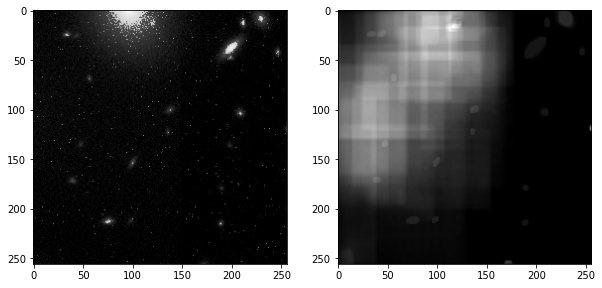

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.imshow(img.numpy().reshape(256, 256), cmap = 'gray')
ax2.imshow(prediction_B, cmap = 'gray');
plt.savefig('prediction_RCNN_NO.pdf');

In [ ]:
eval_img = evaluation_dataset_img3nl.eval_imgs

In [ ]:
evaluation_dataset_img3nl.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
IoU metric: segm
 Avera

# Metrics Evaluation

In [6]:
import pickle
%cd /content/drive/MyDrive/Final Project/AstroStatLearn/results/Mask_RCNN

/content/drive/.shortcut-targets-by-id/12oB0yfCn8EnscXWd4KOG5iZW5xfunRqy/Final Project/AstroStatLearn/results/Mask_RCNN


In [7]:
with open('evaluation3.pickle', 'rb') as f:
  eval3 = pickle.load(f)

In [10]:
with open('evaluation5.pickle', 'rb') as f:
  eval5 = pickle.load(f)

In [9]:
eval3.summarize()  # IMG3 no normalizzata

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.231
IoU metric: segm
 Avera

In [11]:
eval5.summarize()  # IMG3 no normalizzata con rms

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
IoU metric: segm
 Avera

In [12]:
with open('evaluation_dataset_img3.pickle', 'rb') as f:
  evaluation_dataset_img3 = pickle.load(f)

In [14]:
with open('evaluation_dataset_normal.pickle', 'rb') as f:
  evaluation_dataset_normal = pickle.load(f)

In [16]:
with open('evaluation_dataset_img3nl.pickle', 'rb') as f:
  evaluation_dataset_img3nl = pickle.load(f)

In [17]:
evaluation_dataset_img3nl.summarize()  # normale + log

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
IoU metric: segm
 Avera

In [15]:
evaluation_dataset_normal.summarize() # normale norma

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
IoU metric: segm
 Avera

In [13]:
evaluation_dataset_img3.summarize()   # IMG3 normalizzata

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
IoU metric: segm
 Avera

In [33]:
dict_metrics = {'bbox': 0, 'segm': 0}

In [34]:
bbox_metrics = {'AP @[ IoU=0.50:0.95]':  0 ,  
                'AP @[ IoU=0.50]':  0 , 
                'AP @[ IoU=0.75]':  0  , 
                'AR @[ IoU=0.50:0.95]': 0 }
segm_metrics = {'AP @[ IoU=0.50:0.95]':  0 ,  
                'AP @[ IoU=0.50]':  0 , 
                'AP @[ IoU=0.75]':  0  , 
                'AR @[ IoU=0.50:0.95]': 0 }

In [35]:
bbox_metrics['AP @[ IoU=0.50:0.95]'] = [0.005, 0.112  ,0.107, 0.245]
bbox_metrics['AP @[ IoU=0.50]'] = [0.016, 0.422, 0.356, 0.718]
bbox_metrics['AP @[ IoU=0.75]'] = [0.002,  0.025 , 0.041, 0.086]
bbox_metrics['AR @[ IoU=0.50:0.95]'] = [0.036, 0.559, 0.510,0.581]

segm_metrics['AP @[ IoU=0.50:0.95]'] = [0.007, 0.214, 0.193,0.389]
segm_metrics['AP @[ IoU=0.50]'] = [0.023, 0.596 , 0.532,0.780]
segm_metrics['AP @[ IoU=0.75]'] = [0.003,  0.074 , 0.096,0.338]
segm_metrics['AR @[ IoU=0.50:0.95]'] = [0.023, 0.552 , 0.533,0.629]

In [36]:
dict_metrics['bbox'] = bbox_metrics
dict_metrics['segm'] = segm_metrics


In [37]:
import pandas as pd

In [57]:
df = pd.DataFrame.from_dict(dict_metrics, orient="index").stack().to_frame()
df = pd.DataFrame(df[0].values.tolist(), index=df.index)

In [65]:
df.columns = [ 'Image', 'Image w/Normalize','Image Softawe w/Normalize', 'Image Softawe + rms w/Normalize']

In [68]:
df = df.T

In [69]:
df.to_csv('RCNN_metrics.csv')